# Initialization cell

In [1]:
! pip install --upgrade pip
! pip install python-dotenv
! pip install pymorphy2 nltk scikit-learn
! pip install catboost
! pip install xgboost
! pip install -U scikit-learn
! pip install joblib
! pip install --upgrade termcolor
! pip install cloudpickle
! pip install transformers

In [2]:
import pandas as pd
import numpy as np

import gdown
import os
import json

import matplotlib.pyplot as plt

from dataclasses import dataclass, fields, asdict

from typing import List, Optional, Tuple, Dict
import shutil
from dotenv import load_dotenv

import joblib
import cloudpickle
from termcolor import colored

import pymorphy2
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error

from tqdm import tqdm
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from torch.nn.utils.rnn import pack_sequence, pad_sequence

from transformers import BertModel, BertTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device type:', colored(device, 'green'))

[nltk_data] Downloading package punkt to /home/kitsu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kitsu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Device type: cuda


# Preparation cell

In [3]:
ROOT_DIR: str = os.path.dirname(os.path.abspath(os.curdir))
DATASET_PATH: str = f"{ROOT_DIR}/source_data/superset_hr.xlsx"
SKILLS_JSON_PATH: str = f"{ROOT_DIR}/source_data/skills_dictionary.json"
GOOGLE_COLAB_PATH: str = '/content/superset_hr.xlsx'
SKILLS_PRIO_JSON_PATH: str = f"{ROOT_DIR}/source_data/skills_priority.json"

load_dotenv()
SKILL_DICT_URL = os.environ.get('SKILL_DICT_URL')
DATASET_URL = os.environ.get('DATASET_V2_URL')
SKILL_PRIO_URL = os.environ.get('SKILL_PRIO_URL')

if DATASET_URL is None:
    print('>>> .env was not found!', end='\n\n')
    DATASET_URL = input('>>> Provide DATASET url for downloading: ')

    if SKILL_DICT_URL is None: SKILL_DICT_URL = input('>>> Provide JSON url for downloading: ')
    if SKILL_PRIO_URL is None: SKILL_PRIO_URL = input('>>> Provide priorities JSON url for downloading: ')

In [4]:
def get_skill_dict() -> dict[str: list[int]]:
    try:
        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    except FileNotFoundError:
        print(f"Can't open file from path: {SKILLS_JSON_PATH}", end='\n\n')
        file_name = gdown.download(SKILL_DICT_URL, fuzzy=True)
        os.makedirs(os.path.dirname(SKILLS_JSON_PATH), exist_ok=True)
        os.rename(os.path.abspath(file_name), SKILLS_JSON_PATH)
        print(f'Moved to: {SKILLS_JSON_PATH}', end='\n\n')

        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    return data

def get_skill_prio() -> dict[str: dict[str, int]]:
    try:
        with open(file=SKILLS_PRIO_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    except FileNotFoundError:
        print(f"Can't open file from path: {SKILLS_PRIO_JSON_PATH}", end='\n\n')
        file_name = gdown.download(SKILL_PRIO_URL, fuzzy=True)
        os.makedirs(os.path.dirname(SKILLS_PRIO_JSON_PATH), exist_ok=True)
        os.rename(os.path.abspath(file_name), SKILLS_PRIO_JSON_PATH)
        print(f'Moved to: {SKILLS_PRIO_JSON_PATH}', end='\n\n')

        with open(file=SKILLS_PRIO_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    return data


def get_original_dataframe() -> pd.DataFrame:
    try:
        df = pd.read_excel(DATASET_PATH)
    except FileNotFoundError:
        try:
            print(f"Can't open file from path: {DATASET_PATH}", end='\n\n')
            df = pd.read_excel(GOOGLE_COLAB_PATH)
        except FileNotFoundError:
            print(f"Can't open file from path: {GOOGLE_COLAB_PATH}", end='\n\n')
            file_name = gdown.download(DATASET_URL, fuzzy=True)
            os.makedirs(os.path.dirname(DATASET_PATH), exist_ok=True)
            os.rename(os.path.abspath(file_name), DATASET_PATH)
            print(f'Moved to: {DATASET_PATH}', end='\n\n')
            df = pd.read_excel(DATASET_PATH)
    finally:
        print('Success!')
        return df

In [5]:
skills_dict = get_skill_dict()

In [6]:
skill_prio_dict = get_skill_prio()
skill_prio_dict = {k: {key.lower(): value for key, value in v.items()} for k, v in skill_prio_dict.items()}

In [7]:
df_original = get_original_dataframe()

Success!


In [8]:
print(df_original.shape)
df_original.sample(3)

(188833, 21)


,id,income_name,name,published_at,created_at,collected_at,url,area__name,salary__currency,salary__gross,...,address__city,schedule__name,grade,employment__name,key_skills__names,languages__names,exchange_rate,salary_from_gross,salary_to_gross,salary_average
55938,94230945,Системный аналитик,Системный аналитик (System Analyst) / (Розница...,2024-03-04T19:53:56+0300,2024-03-04T19:53:56+0300,2024-03-15 20:37:11.419,https://api.hh.ru/vacancies/94230945?host=hh.ru,Москва,NaN,NaN,...,Москва,Удаленная работа,Middle (3-6),Полная занятость,['Camunda'],[],NaN,NaN,NaN,NaN
17269,93364268,Frontend,Frontend developer (React),2024-02-16T17:43:54+0300,2024-02-16T17:43:54+0300,2024-02-17 08:34:55.057,https://api.hh.ru/vacancies/93364268?host=hh.ru,Минск,NaN,NaN,...,NaN,Полный день,Junior (1-3),Лайфтех,"['JavaScript', 'Git', 'React', 'Redux', 'TypeS...",[],NaN,NaN,NaN,NaN
71712,92397260,Менеджер по продажам,Менеджер по оптовым продажам,2024-02-29T11:23:01+0300,2024-02-29T11:23:01+0300,2024-03-24 16:25:41.465,https://api.hh.ru/vacancies/92397260?host=hh.ru,Новосибирск,NaN,NaN,...,Новосибирск,Полный день,Junior (1-3),Полная занятость,[],[],NaN,NaN,NaN,NaN


# Function & utils cell

In [9]:
def print_df_info(df: pd.DataFrame) -> None:
    print(f"Shape: {df.shape}")
    print('-' * 50)
    display(df.sample(3))
    print('-' * 50)
    display(df.info())

In [10]:
class ClearDataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, save_cols: Optional[List[str]] = None) -> None:
        self.save_cols = save_cols

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'ClearDataFrameTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X[self.save_cols].copy()
        df_new.rename(columns={'income_name': 'income__name'}, inplace=True)
        df_new = df_new.dropna(subset=['salary_from_gross', 'salary_to_gross', 'salary_average'], how='all')
        df_new = df_new.dropna(subset=['income__name'])
        df_new = df_new.drop(['salary__currency', 'exchange_rate'], axis=1)
        return df_new


class RenameDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        pass

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'RenameDataTransformer':
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        df_new.rename(columns={'income_name': 'income__name'}, inplace=True)
        return df_new


class CreateNewCitiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold: int = 75):
        self.threshold = threshold

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'CreateNewCitiesTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        cities = df_new['area__name'].unique()
        city_counts = df_new['area__name'].value_counts()
        N_rows = df_new.shape[0]
        ratios = {city: city_counts[city] / N_rows for city in cities}

        answer = []
        all_percentage = 0
        sorted_dict = {k: v for k, v in sorted(ratios.items(), key=lambda item: item[1], reverse=True)}
        for label, pct in sorted_dict.items():
            all_percentage += pct * 100
            if all_percentage < self.threshold:
                answer.append(label)

        df_new.loc[~df_new['area__name'].isin(answer), 'area__name'] = 'Малый город'
        return df_new
    
    
class SelectProfessionsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, prof_list: Optional[List[str]] = None, whitelist: bool = True) -> None:
        self.prof_list = prof_list
        self.whitelist = whitelist

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'SelectProfessionsTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        if self.whitelist:
            df_new = df_new[df_new['income__name'].isin(self.prof_list)]
        else:
            df_new = df_new[~df_new['income__name'].isin(self.prof_list)]
        return df_new


class FillNaSalaryTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, coef_index: int) -> None:
        self.coef_index = coef_index
    
    @staticmethod
    def get_difference_percentiles(df: pd.DataFrame) -> Tuple[float, float, float]:
        filtered_df = df.dropna(subset=['salary_from_gross', 'salary_to_gross']).copy()
        filtered_df.loc[:, 'difference'] = filtered_df['salary_to_gross'] - filtered_df['salary_from_gross']
        condition = filtered_df['difference'] > 0.8 * filtered_df['salary_to_gross']
        filtered_df.loc[condition, ['salary_from_gross', 'difference']] = np.nan

        filtered_df = filtered_df.dropna(subset=['salary_from_gross', 'salary_to_gross'])

        filtered_df = filtered_df[filtered_df['salary_from_gross'] >= 1000]
        filtered_df = filtered_df[filtered_df['salary_to_gross'] >= 10000]

        filtered_df.loc[:, 'difference_ratio'] = np.where(filtered_df['salary_to_gross'] != 0,
                                                        filtered_df['difference'] / filtered_df['salary_to_gross'],
                                                        np.nan)

        perc25 = filtered_df['difference_ratio'].quantile(0.25)
        perc50 = filtered_df['difference_ratio'].quantile(0.50)
        perc75 = filtered_df['difference_ratio'].quantile(0.75)

        return perc25, perc50, perc75

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'FillNaSalaryTransformer':
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        coef = self.get_difference_percentiles(df_new)[self.coef_index]
        df_new['salary_to_gross'] = df_new['salary_to_gross'].fillna(df_new['salary_from_gross'] / (1 - coef))
        df_new['salary_from_gross'] = df_new['salary_from_gross'].fillna(df_new['salary_to_gross'] * (1 - coef))
        df_new['salary_average'] = df_new['salary_average'].fillna((df_new['salary_to_gross'] + df_new['salary_from_gross']) / 2)

        df_new[['salary_to_gross', 'salary_from_gross', 'salary_average']] = df_new[['salary_to_gross', 'salary_from_gross', 'salary_average']].astype(float)
        return df_new
    

class PreprocessKeySkillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, s_dict: Dict[str, List[str]],
                 p_dict,
                 calc_skills: bool = True,
                 with_skills: bool = True,
                 with_grade: bool = True,
                 with_area: bool = True) -> None:

        self.s_dict = s_dict
        self.p_dict = p_dict
        self.calc_skills = calc_skills
        self.with_skills = with_skills
        self.with_grade = with_grade
        self.with_area = with_area

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'PreprocessKeySkillsTransformer':
        return self

    @staticmethod
    def convert_skills(skill_string: str, skills_dict: Dict[str, List[str]]) -> Tuple[List[str], List[str]]:
        skill_list = eval(skill_string)
        converted_skills = []
        unconverted_skills = []
        for skill in skill_list:
            found = False
            for main_skill, variations in skills_dict.items():
                if skill in variations:
                    converted_skills.append(main_skill)
                    found = True
                    break
            if not found:
                unconverted_skills.append(skill)

        return converted_skills, unconverted_skills


    @staticmethod
    def calculate_skills_quality(skills, profession, p_dict):
        if not skills:
            return 0.0

        skills_importance = p_dict.get(profession, {})

        if not skills_importance:
            return 0.0

        total_importance = sum(skills_importance.values())
        skill_score = sum([skills_importance.get(skill.lower(), 0) for skill in skills])
        quality = skill_score / total_importance
        return min(quality, 1.0)

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()

        if self.calc_skills or self.with_skills:
            df_new[['skills', 'unconverted_skills']] = df_new['key_skills__names'].apply(
                lambda x: pd.Series(self.convert_skills(x, self.s_dict))
            )
            df_new['skills_quality'] = df_new.apply(
                lambda row: self.calculate_skills_quality(row['skills'], row['income__name'], self.p_dict), axis=1
            )
            if not self.with_skills:
                df_new = df_new.drop(['skills', 'unconverted_skills'], axis=1)
            if not self.calc_skills:
                df_new = df_new.drop(['skills_quality'], axis=1)

        df_new = df_new.drop(['key_skills__names'], axis=1)

        if not self.with_grade:
            df_new = df_new.drop(columns=df_new.filter(like='grade').columns, axis=1)

        if not self.with_area:
            df_new = df_new.drop(columns=df_new.filter(like='area_name').columns, axis=1)

        return df_new
    

class ProcessSkillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, freq_cutoff: int = 100, 
                       add_unprocessed: bool = False) -> None:
        self.freq_cutoff = freq_cutoff
        self.add_unprocessed = add_unprocessed

        self.morph = pymorphy2.MorphAnalyzer()
        self.nltk_stop_words = set(stopwords.words('russian'))
        self.custom_words = {',', ':', 'работа', 'активный', 'язык', 'навык',
                             'деловой', 'ведение', 'проведение', 'презентация', 'грамотный'}
        self.stop_words = self.nltk_stop_words.union(self.custom_words)

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'ProcessSkillsTransformer':
        return self

    def tokenize_and_lemmatize(self, skill_list: List[str]) -> List[str]:
        tokens = []
        for skill in skill_list:
            words = word_tokenize(skill)
            lemmas = [self.morph.parse(word.lower())[0].normal_form for word in words if word.lower() not in self.stop_words]
            tokens.extend(lemmas)
        return tokens

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_processed = X.copy()

        def prepare_skills(df: pd.DataFrame, col: str) -> pd.DataFrame:
            df_new = df.copy()
            df_new[col] = df_new[col].apply(self.tokenize_and_lemmatize)
            counts = df_new[col].explode().value_counts()
            frequent = counts[counts >= self.freq_cutoff].index
            df_new[col] = df_new[col].apply(lambda skills: [skill for skill in skills if skill in frequent])
            return df_new

        if self.add_unprocessed:
            df_processed = prepare_skills(df_processed, 'skills')
            df_processed = prepare_skills(df_processed, 'unconverted_skills')
            df_processed['skills_plus'] = df_processed['skills'] + df_processed['unconverted_skills']
        else:
            df_processed['skills_plus'] = df_processed['skills']

        df_processed = df_processed[df_processed['skills_plus'].apply(lambda x: len(x) > 0)]
        df_processed = df_processed.drop(['unconverted_skills', 'skills'], axis=1)
        return df_processed


class VectorizePCASkillsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 n_components: int = 100, 
                 PCA_enable: bool = True, 
                 add_unprocessed: bool = False) -> None:
        
        self.n_components = n_components
        self.PCA_enable = PCA_enable
        self.add_unprocessed = add_unprocessed
        
        if not self.add_unprocessed:
            self.vectorizer = TfidfVectorizer(analyzer=lambda x: x)
        else:
            self.vectorizer = TfidfVectorizer()

        self.pca = PCA(n_components=self.n_components)

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'VectorizePCASkillsTransformer':
        X = X.copy()
        if self.add_unprocessed:
            X['skills_plus'] = X['skills_plus'].apply(lambda x: ' '.join(x))

        self.vectorizer.fit(X['skills_plus'])
        if self.PCA_enable:
            skills_tfidf = self.vectorizer.transform(X['skills_plus'])
            skills_df = pd.DataFrame(skills_tfidf.toarray(), 
                                     columns=self.vectorizer.get_feature_names_out())
            self.pca.fit(skills_df)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_vect = X.copy()

        skills_tfidf = self.vectorizer.transform(df_vect['skills_plus'])
        skills_df = pd.DataFrame(skills_tfidf.toarray(), 
                                 columns=self.vectorizer.get_feature_names_out())
        df_vect = df_vect.reset_index()

        if self.PCA_enable:
            skills_pca = self.pca.transform(skills_df)
            skills_pca_df = pd.DataFrame(skills_pca, 
                                         columns=[f'component_{i+1}' for i in range(skills_pca.shape[1])])
            df_merged = pd.concat([df_vect, skills_pca_df], axis=1)
        else:
            df_merged = pd.concat([df_vect, skills_df], axis=1)

        df_merged = df_merged.drop(['skills_plus', 'index'], axis=1)

        return df_merged


class ExtractFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_param: Optional[str] = None) -> None:
        self.drop_param = drop_param
        self.transformers = [
            ('schedule_name', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['schedule__name']),
            ('grade', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['grade']),
            ('income_name', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['income__name']),
            ('area_name', OneHotEncoder(sparse_output=False, drop=self.drop_param), ['area__name'])
        ]
        self.pipeline = Pipeline(steps=[
            ('column_transformer', ColumnTransformer(transformers=self.transformers, remainder='passthrough'))
        ])

    def fit(self, X: pd.DataFrame, y=None) -> 'ExtractFeaturesTransformer':
        self.pipeline.fit(X)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        df_new = self.pipeline.transform(df_new)
        
        column_names = self.pipeline.named_steps['column_transformer'].get_feature_names_out()
        strings_to_replace = ['remainder__','schedule__name_','income__name_', 'area__name_']
        for string in strings_to_replace:
            column_names = [x.replace(string, '') for x in column_names]
        column_names = [x.replace('grade__grade_', 'grade_') for x in column_names]
        
        df_new = pd.DataFrame(df_new, columns=column_names)

        return df_new


class ConvertTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, new_type: type) -> None:
        self.new_type = new_type

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> 'ConvertTypeTransformer':
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df_new = X.copy()
        df_new: pd.DataFrame = df_new.astype(self.new_type)
        return df_new

# Preprocessing Pipleline

In [11]:
RANDOM_STATE = 42

income_names_IT = ['Frontend', 'Backend', 'DevOps', 'Веб дизайнер', 'QA инженер', 'Mobile',
                   'Project manager', 'Product manager', 'Технический писатель', 'Data Analyst',
                   'Data Engineer', 'Data Scientist', 'Аналитик', 'Бизнес аналитик',
                   'Системный аналитик', 'Руководитель проектов', 'IT Project manager', 'IT Product manager']

income_names_1C = ['1C оператор', '1С эксперт', '1С архитектор', 'Руководитель проектов 1С',
                   '1С методист', '1С администратор', '1C консультант', '1С программист', '1С аналитик']

income_names_other = ['Менеджер по продажам', 'Менеджер по работе с клиентами',
                      'Специалист технической поддержки']

SAVE_COLS = ['income_name', 'area__name', 'schedule__name', 'grade',
            'key_skills__names', 'salary__currency',
            'exchange_rate', 'salary_from_gross', 'salary_to_gross', 'salary_average']


@dataclass
class PreprocessParams:
    BASIC_TRANSFORM: bool = False
    FREQ_CUTOFF: int = 1000
    DROP_PARAM_ONE_HOT = 'first'
    THRESHOLD_CITIES: int = 50
    PERC_NUMBER: int = 0  # 0 - 25% | 1 - 50% | 2 - 75%
    IS_PCA_ENABLE: bool = True
    N_COMPONENTS: int = 100
    ADD_UNPROCESSED: bool = False
    WITH_SKILLS: bool = True
    WITH_GRADE: bool = True
    WITH_AREA: bool = True
    WHITELIST: bool = True
    PROF_LIST: list = None
    VERBOSE: bool = False
    CALC_SKILLS: bool = False

    def __repr__(self):
        field_strings = []
        for field in fields(self):
            field_name = field.name
            field_value = getattr(self, field_name)
            field_strings.append(f"* {field_name}: {field_value}")
        result_str = "\n".join(field_strings)
        sep = colored('\n' + '-' * 30 + '\n', 'cyan')
        return f'\nPreprocess params:{sep}{result_str}'


def get_preprocess_pipeline(params: PreprocessParams) -> Pipeline:
    basic_pipe = Pipeline(steps=[
            ('clear_df', ClearDataFrameTransformer(SAVE_COLS)),
            ('create_new_cities', CreateNewCitiesTransformer(params.THRESHOLD_CITIES)),
            ('select_professions', SelectProfessionsTransformer(params.PROF_LIST, params.WHITELIST)),
            ('fill_na_salary', FillNaSalaryTransformer(params.PERC_NUMBER)),
            ('preprocess_key_skills', PreprocessKeySkillsTransformer(skills_dict,
                                                                     skill_prio_dict,
                                                                     params.CALC_SKILLS,
                                                                     params.WITH_SKILLS,
                                                                     params.WITH_GRADE,
                                                                     params.WITH_AREA))
        ], verbose=params.VERBOSE)

    if params.BASIC_TRANSFORM:
        display(basic_pipe)
        return basic_pipe

    pipe_skill_vectorize = Pipeline(steps=[
            ('process_skills', ProcessSkillsTransformer(params.FREQ_CUTOFF,
                                                        params.ADD_UNPROCESSED)),
            ('vectorize_PCA_skills', VectorizePCASkillsTransformer(params.N_COMPONENTS,
                                                                params.IS_PCA_ENABLE,
                                                                params.ADD_UNPROCESSED))
        ],verbose=params.VERBOSE)

    if params.WITH_SKILLS:
        pipe = Pipeline(steps=[
            ('basic_pipe', basic_pipe),
            ('extract_features', ExtractFeaturesTransformer(params.DROP_PARAM_ONE_HOT)),
            ('skill_vectorize', pipe_skill_vectorize),
            ('convert_type', ConvertTypeTransformer(float))
        ], verbose=params.VERBOSE)
    else:
        pipe = Pipeline(steps=[
            ('basic_pipe', basic_pipe),
            ('extract_features', ExtractFeaturesTransformer(params.DROP_PARAM_ONE_HOT)),
            ('convert_type', ConvertTypeTransformer(float))
        ], verbose=params.VERBOSE)

    print(params, end='\n\n')
    display(pipe)
    return pipe

In [12]:
df_all = get_preprocess_pipeline(PreprocessParams(PROF_LIST=[],
                                                  BASIC_TRANSFORM=True,
                                                  WHITELIST=False,
                                                  IS_PCA_ENABLE=False)).fit_transform(df_original)
print_df_info(df_all)

Pipeline(steps=[('clear_df',
                 ClearDataFrameTransformer(save_cols=['income_name',
                                                      'area__name',
                                                      'schedule__name', 'grade',
                                                      'key_skills__names',
                                                      'salary__currency',
                                                      'exchange_rate',
                                                      'salary_from_gross',
                                                      'salary_to_gross',
                                                      'salary_average'])),
                ('create_new_cities', CreateNewCitiesTransformer(threshold=50)),
                ('select_professions',
                 SelectProfessionsTransformer(prof_l...
                                                                           'indesign',
                                                                           'ADOBE '
                                                                           'INDESIGN',
                                                                           'adobe '
                                                                           'indesign',
                                                                           'adobe '
                                                                           'design',
                                                                           'Adobe '
                                                                           'design',
                                                                           'ADOBE '
                                                                           'DESIGN',
                                                                           'INDESIGN',
                                                                           'indesign',
                                                                           'Indesign'],
                                                        'adobe lightroom': ['ADOBE '
                                                                            'LIGHTROOM',
                                                                            'adobe '
                                                                            'lightroom',
                                                                            'Adobe '
                                                                            'lightroom'],
                                                        'adobe photoshop': ['adobe '
                                                                            'photoshop',
                                                                            'ADOBE '
                                                                            'PHOTOSHOP',
                                                                            'Adobe '
                                                                            'photoshop'],
                                                        'adobe premier': ['Adobe '
                                                                          'premier',
                                                                          'adobe '
                                                                          'premier',
                                                                          'ADOBE '
                                                                          'PREMIER'], ...}))])

Shape: (100453, 9)
--------------------------------------------------


,income__name,area__name,schedule__name,grade,salary_from_gross,salary_to_gross,salary_average,skills,unconverted_skills
146807,Менеджер по продажам,Малый город,Полный день,Junior (1-3),85000.0,100000.000000,92500.000000,[],[]
107077,Специалист технической поддержки,Малый город,Сменный график,Intern (0-1),30510.0,35894.117647,33202.058824,[техническая поддержка],"[Настройка ПК, Настройка ПО]"
18542,Бизнес аналитик,Малый город,Полный день,Junior (1-3),56500.0,79100.000000,67800.000000,[],[]


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100453 entries, 2 to 188832
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   income__name        100453 non-null  object 
 1   area__name          100453 non-null  object 
 2   schedule__name      100453 non-null  object 
 3   grade               100453 non-null  object 
 4   salary_from_gross   100453 non-null  float64
 5   salary_to_gross     100453 non-null  float64
 6   salary_average      100453 non-null  float64
 7   skills              100453 non-null  object 
 8   unconverted_skills  100453 non-null  object 
dtypes: float64(3), object(6)
memory usage: 7.7+ MB


None

# Model RNN & BERT vectorization

In [13]:
# words_and_vec = {k: None for k in list(skills_dict.keys())}
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model = BertModel.from_pretrained('bert-base-multilingual-cased')

# def get_word_vector(word):
#     inputs = tokenizer(word, return_tensors='pt')
#     outputs = model(**inputs)
#     vector = outputs.last_hidden_state[:, 0, :].detach().numpy()
#     return vector.flatten()

# words_and_vec = {k: get_word_vector(k) for k in list(skills_dict.keys())}

In [14]:
# def get_transforms_for_dl(df, word_dict):

#     def skills_to_vectors(skills_list):
#         return [word_dict[skill] for skill in skills_list]

#     df_new = df.copy()
#     df_new = df_new.drop(['salary_from_gross', 'salary_to_gross', 'unconverted_skills'], axis=1)
#     df_new = df_new[df_new['skills'].apply(lambda x: len(x) > 0)]
#     df_new['skills'] = df_new['skills'].apply(skills_to_vectors)

#     # One-hot encoding for cols: 'area_name', 'shedule_name', 'grade'
#     pipe_for_dl = Pipeline(steps=[
#         ('one-hot', ExtractFeaturesTransformer(drop_param='first'))
#     ])

#     df_new = pipe_for_dl.fit_transform(df_new)

#     return df_new

In [15]:
# def pad_skills(skills_list, max_len=None):
#     if not max_len:
#         max_len = max(len(skills) for skills in skills_list)
#     padded_skills = [np.pad(skills, ((0, max_len - len(skills)), (0, 0)), 'constant') for skills in skills_list]
#     return padded_skills

# class SalaryDataset(Dataset):
#     def __init__(self, X, y, max_skill_len=None):
#         self.tabular_data = torch.tensor(np.array(X.drop(columns=['skills']).values.tolist(), dtype=np.float32))
#         self.skills_data = pad_skills(X['skills'], max_skill_len)
#         self.skills_data = torch.tensor(self.skills_data, dtype=torch.float32)
#         self.labels = torch.tensor(y.values.astype(np.float32)).view(-1, 1)
    
#     def __len__(self):
#         return len(self.tabular_data)
    
#     def __getitem__(self, idx):
#         return self.tabular_data[idx], self.skills_data[idx], self.labels[idx]

In [16]:
# df_all_dl = get_transforms_for_dl(df_all, words_and_vec)

# X = df_all_dl.drop(['salary_average'], axis=1)
# y = df_all_dl['salary_average']

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=42, test_size=0.2)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=42, test_size=0.5)

# train_dataset = SalaryDataset(X_train, y_train)
# validation_dataset = SalaryDataset(X_val, y_val)
# test_dataset = SalaryDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/tmp/ipykernel_56862/2570921115.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403388920/work/torch/csrc/utils/tensor_new.cpp:275.)
  self.skills_data = torch.tensor(self.skills_data, dtype=torch.float32)


In [19]:
# class SalaryPredictionModel(nn.Module):
#     def __init__(self, input_dim, skills_dim, hidden_dim):
#         super(SalaryPredictionModel, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.fc2 = nn.Linear(128, 64)
        
#         self.lstm = nn.LSTM(skills_dim, hidden_dim, batch_first=True)
#         self.fc3 = nn.Linear(hidden_dim, 64)
        
#         self.fc4 = nn.Linear(64 + 64, 1)
    
#     def forward(self, tabular_data, skills_data):
#         x1 = torch.relu(self.fc1(tabular_data))
#         x1 = torch.relu(self.fc2(x1))
        
#         packed_skills = pack_sequence(skills_data, enforce_sorted=False)
#         lstm_out, _ = self.lstm(packed_skills)
#         lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        
#         last_lstm_out = lstm_out[:, -1, :]
        
#         x2 = torch.relu(self.fc3(last_lstm_out))
        
#         x = torch.cat((x1, x2), dim=1)
#         x = self.fc4(x)
#         return x

# input_dim = X_train.drop(columns=['skills']).shape[1]
# skills_dim = len(X_train['skills'].iloc[0][0])
# hidden_dim = 64

# model = SalaryPredictionModel(input_dim, skills_dim, hidden_dim)

# criterion = nn.L1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# num_epochs = 20

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for tabular_data, skills_data, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(tabular_data, skills_data)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
    
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# model.eval()
# with torch.no_grad():
#     y_pred = []
#     y_true = []
#     for tabular_data, skills_data, labels in test_loader:
#         outputs = model(tabular_data, skills_data)
#         y_pred.extend(outputs.numpy())
#         y_true.extend(labels.numpy())

#     from sklearn.metrics import mean_squared_error
#     mse = mean_squared_error(y_true, y_pred)
#     print(f'Mean Squared Error: {mse:.4f}')

# print("Примеры предсказаний:")
# for i in range(3):
#     print(f"Предсказанная зарплата: {y_pred[i][0]:.2f}, Истинная зарплата: {y_true[i][0]:.2f}")

# Preprocess IT/1C/other

In [20]:
preprocess_params = {
    "IT": PreprocessParams(
        WITH_SKILLS=True,
        WITH_GRADE=True,
        WITH_AREA=True,
        IS_PCA_ENABLE=False,
        PROF_LIST=income_names_IT
    ),
    "1C": PreprocessParams(
        WITH_SKILLS=True,
        WITH_GRADE=True,
        WITH_AREA=True,
        PROF_LIST=income_names_1C
    ),
    "other": PreprocessParams(
        WITH_SKILLS=False,
        WITH_GRADE=True,
        WITH_AREA=True,
        PROF_LIST=income_names_other
    )
}

results = {}    

width = 40

for key, params in preprocess_params.items():
    print(colored(f"{key:-^{width}}", 'green'))
    pipeline = get_preprocess_pipeline(params).fit(df_original)
    df_processed = pipeline.transform(df_original)
    results[key] = {
        "data": df_processed,
        "pipe": pipeline,
        "Params": params,
        "pretrained_model": None,
        "rmse_score": None
    }

df_after_preprocess_IT = results["IT"]["data"]
df_after_preprocess_1C = results["1C"]["data"]
df_after_preprocess_other = results["other"]["data"]

-------------------IT-------------------

Preprocess params:
------------------------------
* BASIC_TRANSFORM: False
* FREQ_CUTOFF: 1000
* THRESHOLD_CITIES: 50
* PERC_NUMBER: 0
* IS_PCA_ENABLE: False
* N_COMPONENTS: 100
* ADD_UNPROCESSED: False
* WITH_SKILLS: True
* WITH_GRADE: True
* WITH_AREA: True
* WHITELIST: True
* PROF_LIST: ['Frontend', 'Backend', 'DevOps', 'Веб дизайнер', 'QA инженер', 'Mobile', 'Project manager', 'Product manager', 'Технический писатель', 'Data Analyst', 'Data Engineer', 'Data Scientist', 'Аналитик', 'Бизнес аналитик', 'Системный аналитик', 'Руководитель проектов', 'IT Project manager', 'IT Product manager']
* VERBOSE: False
* CALC_SKILLS: False



Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  ClearDataFrameTransformer(save_cols=['income_name',
                                                                       'area__name',
                                                                       'schedule__name',
                                                                       'grade',
                                                                       'key_skills__names',
                                                                       'salary__currency',
                                                                       'exchange_rate',
                                                                       'salary_from_gross',
                                                                       'salary_to_gross',
                                                                       'salary_average'])),
                                 ('create_new_cities',
                                  CreateNewCitiesTransformer(threshold=50)),
                                 ('select_professions',
                                  Selec...
                                                                                           'adobe '
                                                                                           'premier',
                                                                                           'ADOBE '
                                                                                           'PREMIER'], ...}))])),
                ('extract_features',
                 ExtractFeaturesTransformer(drop_param='first')),
                ('skill_vectorize',
                 Pipeline(steps=[('process_skills',
                                  ProcessSkillsTransformer(freq_cutoff=1000)),
                                 ('vectorize_PCA_skills',
                                  VectorizePCASkillsTransformer(PCA_enable=False))])),
                ('convert_type',
                 ConvertTypeTransformer(new_type=<class 'float'>))])

-------------------1C-------------------

Preprocess params:
------------------------------
* BASIC_TRANSFORM: False
* FREQ_CUTOFF: 1000
* THRESHOLD_CITIES: 50
* PERC_NUMBER: 0
* IS_PCA_ENABLE: True
* N_COMPONENTS: 100
* ADD_UNPROCESSED: False
* WITH_SKILLS: True
* WITH_GRADE: True
* WITH_AREA: True
* WHITELIST: True
* PROF_LIST: ['1C оператор', '1С эксперт', '1С архитектор', 'Руководитель проектов 1С', '1С методист', '1С администратор', '1C консультант', '1С программист', '1С аналитик']
* VERBOSE: False
* CALC_SKILLS: False



Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  ClearDataFrameTransformer(save_cols=['income_name',
                                                                       'area__name',
                                                                       'schedule__name',
                                                                       'grade',
                                                                       'key_skills__names',
                                                                       'salary__currency',
                                                                       'exchange_rate',
                                                                       'salary_from_gross',
                                                                       'salary_to_gross',
                                                                       'salary_average'])),
                                 ('create_new_cities',
                                  CreateNewCitiesTransformer(threshold=50)),
                                 ('select_professions',
                                  Selec...
                                                                         'adobe premier': ['Adobe '
                                                                                           'premier',
                                                                                           'adobe '
                                                                                           'premier',
                                                                                           'ADOBE '
                                                                                           'PREMIER'], ...}))])),
                ('extract_features',
                 ExtractFeaturesTransformer(drop_param='first')),
                ('skill_vectorize',
                 Pipeline(steps=[('process_skills',
                                  ProcessSkillsTransformer(freq_cutoff=1000)),
                                 ('vectorize_PCA_skills',
                                  VectorizePCASkillsTransformer())])),
                ('convert_type',
                 ConvertTypeTransformer(new_type=<class 'float'>))])

-----------------other------------------

Preprocess params:
------------------------------
* BASIC_TRANSFORM: False
* FREQ_CUTOFF: 1000
* THRESHOLD_CITIES: 50
* PERC_NUMBER: 0
* IS_PCA_ENABLE: True
* N_COMPONENTS: 100
* ADD_UNPROCESSED: False
* WITH_SKILLS: False
* WITH_GRADE: True
* WITH_AREA: True
* WHITELIST: True
* PROF_LIST: ['Менеджер по продажам', 'Менеджер по работе с клиентами', 'Специалист технической поддержки']
* VERBOSE: False
* CALC_SKILLS: False



Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  ClearDataFrameTransformer(save_cols=['income_name',
                                                                       'area__name',
                                                                       'schedule__name',
                                                                       'grade',
                                                                       'key_skills__names',
                                                                       'salary__currency',
                                                                       'exchange_rate',
                                                                       'salary_from_gross',
                                                                       'salary_to_gross',
                                                                       'salary_average'])),
                                 ('create_new_cities',
                                  CreateNewCitiesTransformer(threshold=50)),
                                 ('select_professions',
                                  Selec...
                                                                                             'LIGHTROOM',
                                                                                             'adobe '
                                                                                             'lightroom',
                                                                                             'Adobe '
                                                                                             'lightroom'],
                                                                         'adobe photoshop': ['adobe '
                                                                                             'photoshop',
                                                                                             'ADOBE '
                                                                                             'PHOTOSHOP',
                                                                                             'Adobe '
                                                                                             'photoshop'],
                                                                         'adobe premier': ['Adobe '
                                                                                           'premier',
                                                                                           'adobe '
                                                                                           'premier',
                                                                                           'ADOBE '
                                                                                           'PREMIER'], ...},
                                                                 with_skills=False))])),
                ('extract_features',
                 ExtractFeaturesTransformer(drop_param='first')),
                ('convert_type',
                 ConvertTypeTransformer(new_type=<class 'float'>))])

In [21]:
print_df_info(df_after_preprocess_IT)

print_df_info(df_after_preprocess_1C)

print_df_info(df_after_preprocess_other)

Shape: (14708, 460)
--------------------------------------------------


,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__Data Analyst,income_name__Data Engineer,income_name__Data Scientist,...,финансовый контроль,функциональное тестирование,художественный вкус,ценообразование,чувство вкуса,чувство стиля,эконометрика,экономика,экономический анализ,эксплуатационные документы
10940,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1668,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5655,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14708 entries, 0 to 14707
Columns: 460 entries, schedule_name__Гибкий график to эксплуатационные документы
dtypes: float64(460)
memory usage: 51.6 MB


None

Shape: (7510, 125)
--------------------------------------------------


,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__1C оператор,income_name__1С администратор,income_name__1С аналитик,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
2266,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.005221,-0.013146,-0.007121,0.003097,-0.002682,-0.001346,-0.009628,-0.003209,0.002570,-0.005433
5331,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.059631,0.065732,-0.065973,-0.035098,-0.002619,-0.008205,0.006635,-0.001817,0.007207,-0.006344
4386,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.014970,-0.002411,0.000720,-0.227124,0.026607,-0.148830,0.022957,0.068311,0.024638,0.027507


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7510 entries, 0 to 7509
Columns: 125 entries, schedule_name__Гибкий график to component_100
dtypes: float64(125)
memory usage: 7.2 MB


None

Shape: (57533, 19)
--------------------------------------------------


,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__Менеджер по работе с клиентами,income_name__Специалист технической поддержки,area_name__Казань,area_name__Краснодар,area_name__Малый город,area_name__Москва,area_name__Нижний Новгород,area_name__Новосибирск,area_name__Санкт-Петербург,salary_from_gross,salary_to_gross,salary_average
50759,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,93112.0,116390.0,104751.0
26128,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60000.0,150000.0,105000.0
11762,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,60000.0,75000.0,67500.0


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57533 entries, 0 to 57532
Data columns (total 19 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   schedule_name__Гибкий график                   57533 non-null  float64
 1   schedule_name__Полный день                     57533 non-null  float64
 2   schedule_name__Сменный график                  57533 non-null  float64
 3   schedule_name__Удаленная работа                57533 non-null  float64
 4   grade_Junior (1-3)                             57533 non-null  float64
 5   grade_Middle (3-6)                             57533 non-null  float64
 6   grade_Senior (>6)                              57533 non-null  float64
 7   income_name__Менеджер по работе с клиентами    57533 non-null  float64
 8   income_name__Специалист технической поддержки  57533 non-null  float64
 9  

None

# Deep Learning Solution

In [13]:
class SparseRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(SparseRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.5)
        self.leaky_relu = nn.LeakyReLU(0.1)
    
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x.to_dense()))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc4(x))
        x = self.leaky_relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [36]:
def train_DL_model(X_df, y_df, model):

    X = X_df.values 
    y = y_df.values

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=42, test_size=0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=42, test_size=0.5)

    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    l1_loss = nn.L1Loss()
    mse_loss = nn.MSELoss()

    criterion = l1_loss
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    num_epochs = 200
    patience = 5
    best_val_loss = float('inf')
    early_stop_counter = 0
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_history.append(epoch_loss)
        
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_history.append(val_epoch_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')
        
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping")
                break


    model.load_state_dict(torch.load('best_model.pth'))

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        l1_lose = l1_loss(y_pred, y_test).item()
        mse = mse_loss(y_pred, y_test).item()
        rmse = np.sqrt(mse)
        mape = torch.mean(torch.abs((y_test - y_pred) / y_test)).item() * 100

    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.2f}%')

    plt.plot(train_history, label='Training Loss')
    plt.plot(val_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Fitting Model

In [25]:
param_grid = [
        {
            'model': [Ridge(random_state=RANDOM_STATE)]
        },
        {
            'model': [CatBoostRegressor(verbose=False,
                                        random_state=RANDOM_STATE)]
        },
        {
            'model': [XGBRegressor(random_state=RANDOM_STATE)]
        },
        {
            'model': [RandomForestRegressor(verbose=False, n_jobs=-1, random_state=RANDOM_STATE)]
        },
        {
            'model': [DecisionTreeRegressor(random_state=RANDOM_STATE,
                                            criterion='friedman_mse')]
        }
]

mape = make_scorer(mean_absolute_percentage_error)
rmse = make_scorer(root_mean_squared_error)
mse = make_scorer(mean_squared_error)

In [26]:
def train(data, estimator, n_top_features=10):
    X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'], axis=1)
    y = data['salary_average']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    rmse_score = root_mean_squared_error(y_test, y_pred)
    print(rmse_score)

    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:n_top_features]
    top_importances = importances[top_indices]
    top_features = X.columns[top_indices]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(n_top_features), top_importances, align='center')
    plt.xticks(range(n_top_features), top_features, rotation=90)
    plt.xlim([-1, n_top_features])
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    return rmse_score, estimator

# DEMO preprocess & fitting

In [ ]:
def get_prediction_pipeline(params: PreprocessParams) -> Pipeline:
    pipe: Pipeline = Pipeline(steps=[
        ('rename_cols', RenameDataTransformer()),
        ('one-hot', ExtractFeaturesTransformer(drop_param=params.DROP_PARAM_ONE_HOT))
    ], verbose=params.VERBOSE)

    if params.WITH_SKILLS:
        pipe: Pipeline = Pipeline(steps=[
            ('basic_pipe', pipe),
            ('process_scills', ProcessSkillsTransformer(freq_cutoff=params.FREQ_CUTOFF)),
            ('vectorize_skills', VectorizePCASkillsTransformer(n_components=params.N_COMPONENTS,
                                                               PCA_enable=params.IS_PCA_ENABLE)),
            ('convert_type', ConvertTypeTransformer(float))
        ], verbose=params.VERBOSE)
    else:
        pipe: Pipeline = Pipeline(steps=[
            ('basic_pipe', pipe),
            ('convert_type', ConvertTypeTransformer(float))
        ], verbose=params.VERBOSE)

    display(pipe)
    return pipe

def train_model(X, y, estimator):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)

    rmse_score = root_mean_squared_error(y_test, y_pred)
    print(rmse_score)
    return estimator

def export_results_for_prediction(result_dict: Dict, folder_name: str = 'output') -> None:
    for key, value in result_dict.items():
        folder_path = f"{folder_name}/{key}"
        os.makedirs(folder_path, exist_ok=True)
        output_dir_path = f"{ROOT_DIR}/Notebooks/{folder_path}"
        print(f'\n>>> Folder was created: {colored(output_dir_path, "green")}')

        if key != 'all_data':
            value['data_before'].to_excel(f"{output_dir_path}/data_before.xlsx")
            value['data_after'].to_excel(f"{output_dir_path}/data_after.xlsx")
            print('>>> Data frames were exported')
        else:
            print('>>> All data is processing. Skip saving DataFrames')

        if key != 'all_data':
            joblib.dump(value['pretrained_model'], f'{output_dir_path}/model_{key}.pkl')
        else:
            torch.save(value['pretrained_model'].state_dict(), f'{output_dir_path}/best_model_cuda.pth')
            model = SparseRegressionModel(470)
            model.load_state_dict(torch.load(f'{output_dir_path}/best_model_cuda.pth', map_location='cpu'))
            torch.save(model.state_dict(), f'{output_dir_path}/best_model_cpu.pth')
        
        print('>>> Model was exported')

        with open(f'{output_dir_path}/params.json', 'w', encoding='utf-8') as f:
            json.dump(asdict(value['Params']), f, ensure_ascii=False)

        print('>>> Preprocessing params were exported')

        with open(f'{output_dir_path}/pipe_{key}.pkl', 'wb') as f:
            cloudpickle.dump(value['pipe'], f)
            print('>>> Pipeline was exported')

    zip_path = f"{ROOT_DIR}/Notebooks/{folder_name}"
    archived = shutil.make_archive('output', 'zip', zip_path)

    if os.path.exists(f'{zip_path}.zip'):
        print(f"\n>>> Arhive was created: {colored(archived, 'green')}") 
    else: 
        print('\n>>>', colored("ZIP file not created", 'red'))

-------------------IT-------------------


Pipeline(steps=[('clear_df',
                 ClearDataFrameTransformer(save_cols=['income_name',
                                                      'area__name',
                                                      'schedule__name', 'grade',
                                                      'key_skills__names',
                                                      'salary__currency',
                                                      'exchange_rate',
                                                      'salary_from_gross',
                                                      'salary_to_gross',
                                                      'salary_average'])),
                ('create_new_cities', CreateNewCitiesTransformer(threshold=50)),
                ('select_professions',
                 SelectProfessionsTransformer(prof_l...
                                                                           'indesign',
                                                                           'ADOBE '
                                                                           'INDESIGN',
                                                                           'adobe '
                                                                           'indesign',
                                                                           'adobe '
                                                                           'design',
                                                                           'Adobe '
                                                                           'design',
                                                                           'ADOBE '
                                                                           'DESIGN',
                                                                           'INDESIGN',
                                                                           'indesign',
                                                                           'Indesign'],
                                                        'adobe lightroom': ['ADOBE '
                                                                            'LIGHTROOM',
                                                                            'adobe '
                                                                            'lightroom',
                                                                            'Adobe '
                                                                            'lightroom'],
                                                        'adobe photoshop': ['adobe '
                                                                            'photoshop',
                                                                            'ADOBE '
                                                                            'PHOTOSHOP',
                                                                            'Adobe '
                                                                            'photoshop'],
                                                        'adobe premier': ['Adobe '
                                                                          'premier',
                                                                          'adobe '
                                                                          'premier',
                                                                          'ADOBE '
                                                                          'PREMIER'], ...}))])

,income__name,area__name,schedule__name,grade,salary_from_gross,salary_to_gross,salary_average,skills,unconverted_skills
48,Backend,Санкт-Петербург,Полный день,Middle (3-6),169500.000000,195576.923077,182538.461538,"[базы данных, php, jquery, html, css, веб-прог...",[]
54,Backend,Москва,Удаленная работа,Middle (3-6),200000.000000,230769.230769,215384.615385,"[git, базы данных, php, ооп]","[Composer, Backend]"
55,Backend,Санкт-Петербург,Удаленная работа,Middle (3-6),200000.000000,230769.230769,215384.615385,"[git, базы данных, php, ооп]","[Composer, Backend]"
57,Backend,Санкт-Петербург,Удаленная работа,Middle (3-6),339000.000000,508500.000000,423750.000000,"[git, kafka, postgresql, docker, удаленная раб...","[Unit Testing, PostGis]"
61,Backend,Москва,Полный день,Junior (1-3),135600.000000,156461.538462,146030.769231,[],[PHP/Laravel]
...,...,...,...,...,...,...,...,...,...
188787,Frontend,Санкт-Петербург,Полный день,Junior (1-3),56500.000000,113000.000000,84750.000000,[],[]
188792,Frontend,Москва,Удаленная работа,Middle (3-6),226000.000000,260769.230769,243384.615385,[],[]
188806,Frontend,Москва,Удаленная работа,Senior (>6),303333.333333,350000.000000,326666.666667,[],[]
188819,Frontend,Екатеринбург,Удаленная работа,Middle (3-6),195866.666667,226000.000000,210933.333333,[],[]


Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('rename_cols', RenameDataTransformer()),
                                 ('one-hot',
                                  ExtractFeaturesTransformer(drop_param='first'))])),
                ('process_scills', ProcessSkillsTransformer(freq_cutoff=1000)),
                ('vectorize_skills', VectorizePCASkillsTransformer()),
                ('convert_type',
                 ConvertTypeTransformer(new_type=<class 'float'>))])

,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__Data Analyst,income_name__Data Engineer,income_name__Data Scientist,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.117923,0.028787,-0.054364,-0.031791,0.025285,0.033030,-0.011349,-0.031619,-0.032388,-0.024192
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.041560,-0.016747,0.039834,0.046796,-0.057561,-0.037694,-0.010967,0.096754,-0.009800,0.025195
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.041560,-0.016747,0.039834,0.046796,-0.057561,-0.037694,-0.010967,0.096754,-0.009800,0.025195
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.015294,-0.016873,-0.066962,-0.041689,0.010107,-0.011721,0.016120,0.001139,-0.044655,0.028998
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.114817,0.017058,-0.073442,-0.041334,0.025816,0.037290,-0.016080,-0.040372,-0.023425,-0.022695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14703,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.000231,0.098239,0.101496,-0.268226,0.024446,0.023324,-0.044930,-0.006272,0.031669,0.011089
14704,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.002045,-0.011220,0.020033,0.011943,0.021018,-0.001205,0.013978,-0.021828,-0.010741,-0.009847
14705,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.006800,0.006571,0.005648,0.017056,0.011026,0.001764,0.004630,-0.022371,-0.004331,-0.004794
14706,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.002045,-0.011220,0.020033,0.011943,0.021018,-0.001205,0.013978,-0.021828,-0.010741,-0.009847


35308.715293100424
-------------------1C-------------------


Pipeline(steps=[('clear_df',
                 ClearDataFrameTransformer(save_cols=['income_name',
                                                      'area__name',
                                                      'schedule__name', 'grade',
                                                      'key_skills__names',
                                                      'salary__currency',
                                                      'exchange_rate',
                                                      'salary_from_gross',
                                                      'salary_to_gross',
                                                      'salary_average'])),
                ('create_new_cities', CreateNewCitiesTransformer(threshold=50)),
                ('select_professions',
                 SelectProfessionsTransformer(prof_l...
                                                                           'indesign',
                                                                           'ADOBE '
                                                                           'INDESIGN',
                                                                           'adobe '
                                                                           'indesign',
                                                                           'adobe '
                                                                           'design',
                                                                           'Adobe '
                                                                           'design',
                                                                           'ADOBE '
                                                                           'DESIGN',
                                                                           'INDESIGN',
                                                                           'indesign',
                                                                           'Indesign'],
                                                        'adobe lightroom': ['ADOBE '
                                                                            'LIGHTROOM',
                                                                            'adobe '
                                                                            'lightroom',
                                                                            'Adobe '
                                                                            'lightroom'],
                                                        'adobe photoshop': ['adobe '
                                                                            'photoshop',
                                                                            'ADOBE '
                                                                            'PHOTOSHOP',
                                                                            'Adobe '
                                                                            'photoshop'],
                                                        'adobe premier': ['Adobe '
                                                                          'premier',
                                                                          'adobe '
                                                                          'premier',
                                                                          'ADOBE '
                                                                          'PREMIER'], ...}))])

,income__name,area__name,schedule__name,grade,salary_from_gross,salary_to_gross,salary_average,skills,unconverted_skills
2,1С программист,Санкт-Петербург,Полный день,Middle (3-6),203000.000000,218615.384615,210807.692308,"[1с программирование, 1с: предприятие]",[]
5,1С программист,Нижний Новгород,Удаленная работа,Middle (3-6),169500.000000,282500.000000,226000.000000,[],[]
9,1С программист,Санкт-Петербург,Полный день,Middle (3-6),169500.000000,182538.461538,176019.230769,"[1с: предприятие, аналитическое мышление, 1с п...",[]
11,1С программист,Москва,Полный день,Middle (3-6),169500.000000,182538.461538,176019.230769,"[1с программирование, 1с: предприятие, 1с: пре...",[]
12,1С программист,Санкт-Петербург,Полный день,Junior (1-3),135600.000000,146030.769231,140815.384615,"[1с: комплексная автоматизация, 1с программиро...",[СКД]
...,...,...,...,...,...,...,...,...,...
187587,1С архитектор,Москва,Полный день,Middle (3-6),157392.857143,169500.000000,163446.428571,[],[]
187588,1С архитектор,Москва,Удаленная работа,Middle (3-6),339000.000000,365076.923077,352038.461538,[],[]
187606,1С архитектор,Москва,Удаленная работа,Middle (3-6),314785.714286,339000.000000,326892.857143,[],[]
187607,1С архитектор,Москва,Удаленная работа,Senior (>6),314785.714286,339000.000000,326892.857143,[],[]


Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('rename_cols', RenameDataTransformer()),
                                 ('one-hot',
                                  ExtractFeaturesTransformer(drop_param='first'))])),
                ('process_scills', ProcessSkillsTransformer(freq_cutoff=1000)),
                ('vectorize_skills', VectorizePCASkillsTransformer()),
                ('convert_type',
                 ConvertTypeTransformer(new_type=<class 'float'>))])

,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__1C оператор,income_name__1С администратор,income_name__1С аналитик,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000100,0.002628,-0.000291,-0.000581,-0.001019,0.001502,-0.000599,-0.000907,-0.000294,0.001007
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.006413,-0.009903,0.000878,-0.000079,-0.000186,-0.001262,-0.003270,0.001067,0.002814,-0.000178
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000336,0.004185,0.002421,-0.003567,-0.001311,0.001171,0.001632,-0.000056,0.000729,0.001039
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.006348,0.001891,-0.008805,-0.005537,-0.002651,-0.001896,-0.001348,0.000397,-0.000682,-0.000032
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.034755,0.017738,0.001324,0.110601,0.089346,-0.213480,0.035201,0.095915,0.017065,0.007939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7505,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.004793,-0.013743,-0.002696,0.005533,0.001033,0.001213,-0.002840,-0.000700,-0.002569,-0.002804
7506,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.004793,-0.013743,-0.002696,0.005533,0.001033,0.001213,-0.002840,-0.000700,-0.002569,-0.002804
7507,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.021899,-0.020830,0.000503,0.003665,0.000526,0.003046,-0.004358,0.001099,-0.003952,-0.009178
7508,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000697,-0.002539,-0.002281,0.001380,-0.000620,0.002177,-0.001041,0.000359,-0.000411,-0.000920


26195.18154195919
-----------------other------------------


Pipeline(steps=[('clear_df',
                 ClearDataFrameTransformer(save_cols=['income_name',
                                                      'area__name',
                                                      'schedule__name', 'grade',
                                                      'key_skills__names',
                                                      'salary__currency',
                                                      'exchange_rate',
                                                      'salary_from_gross',
                                                      'salary_to_gross',
                                                      'salary_average'])),
                ('create_new_cities', CreateNewCitiesTransformer(threshold=50)),
                ('select_professions',
                 SelectProfessionsTransformer(prof_l...
                                                                           'indesign',
                                                                           'ADOBE '
                                                                           'INDESIGN',
                                                                           'adobe '
                                                                           'indesign',
                                                                           'adobe '
                                                                           'design',
                                                                           'Adobe '
                                                                           'design',
                                                                           'ADOBE '
                                                                           'DESIGN',
                                                                           'INDESIGN',
                                                                           'indesign',
                                                                           'Indesign'],
                                                        'adobe lightroom': ['ADOBE '
                                                                            'LIGHTROOM',
                                                                            'adobe '
                                                                            'lightroom',
                                                                            'Adobe '
                                                                            'lightroom'],
                                                        'adobe photoshop': ['adobe '
                                                                            'photoshop',
                                                                            'ADOBE '
                                                                            'PHOTOSHOP',
                                                                            'Adobe '
                                                                            'photoshop'],
                                                        'adobe premier': ['Adobe '
                                                                          'premier',
                                                                          'adobe '
                                                                          'premier',
                                                                          'ADOBE '
                                                                          'PREMIER'], ...}))])

,income__name,area__name,schedule__name,grade,salary_from_gross,salary_to_gross,salary_average,skills,unconverted_skills
20195,Менеджер по продажам,Малый город,Полный день,Intern (0-1),45200.0,56500.0,50850.0,"[активные продажи, ведение переговоров, делова...","[Работа с дебиторской задолженностью, Ведение ..."
20197,Менеджер по продажам,Екатеринбург,Полный день,Intern (0-1),90400.0,113000.0,101700.0,"[активные продажи, навыки переговоров, грамотн...","[входящие звонки, Консультирование клиентов по..."
20198,Менеджер по продажам,Малый город,Полный день,Intern (0-1),53000.0,66250.0,59625.0,[работа в команде],"[работа из дома, работа на дому, звонки]"
20199,Менеджер по продажам,Нижний Новгород,Полный день,Intern (0-1),80000.0,100000.0,90000.0,"[развитие продаж, заключение договоров, делова...","[Холодные звонки, B2B Продажи, Работа с возраж..."
20200,Менеджер по продажам,Санкт-Петербург,Полный день,Middle (3-6),250000.0,312500.0,281250.0,"[деловая коммуникация, поиск и привлечение кли...","[Деловая этика, HoReCa, Продажи через дистрибь..."
...,...,...,...,...,...,...,...,...,...
177305,Специалист технической поддержки,Москва,Полный день,Junior (1-3),113000.0,141250.0,127125.0,[],[]
177307,Специалист технической поддержки,Москва,Полный день,Junior (1-3),135600.0,169500.0,152550.0,[],[]
177308,Специалист технической поддержки,Москва,Удаленная работа,Intern (0-1),35000.0,43750.0,39375.0,[],[]
177309,Специалист технической поддержки,Москва,Полный день,Intern (0-1),80000.0,100000.0,90000.0,[],[]


Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('rename_cols', RenameDataTransformer()),
                                 ('one-hot',
                                  ExtractFeaturesTransformer(drop_param='first'))])),
                ('process_scills', ProcessSkillsTransformer(freq_cutoff=1000)),
                ('vectorize_skills', VectorizePCASkillsTransformer()),
                ('convert_type',
                 ConvertTypeTransformer(new_type=<class 'float'>))])

,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__Менеджер по работе с клиентами,income_name__Специалист технической поддержки,area_name__Казань,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000641,-0.001172,-0.001294,0.000972,-0.001843,0.001402,-0.001513,0.001775,-0.000203,0.000546
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000564,-0.000253,-0.000921,0.001039,-0.000929,-0.000370,0.001781,0.000245,0.000607,0.000332
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000958,0.001325,0.005717,-0.007532,0.003969,-0.005898,0.001939,-0.004686,-0.001189,-0.000909
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000055,-0.000507,-0.002302,0.002143,-0.001439,0.002679,-0.000410,0.002094,0.000550,0.000802
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000579,0.000549,0.002151,-0.003394,0.002075,-0.002881,0.000911,-0.002933,-0.000734,-0.000403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27891,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.001331,0.001244,0.002859,-0.004091,0.000893,-0.004885,0.003653,-0.003655,-0.000581,-0.000605
27892,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.000716,0.001586,0.002157,-0.001670,0.000631,-0.001555,-0.002460,-0.000703,-0.000708,0.000074
27893,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.001331,0.001244,0.002859,-0.004091,0.000893,-0.004885,0.003653,-0.003655,-0.000581,-0.000605
27894,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.000736,-0.005182,0.008815,-0.009887,0.001996,-0.006069,0.000898,-0.003304,-0.001715,-0.000186


22343.874010964057
----------------all_data----------------


Pipeline(steps=[('clear_df',
                 ClearDataFrameTransformer(save_cols=['income_name',
                                                      'area__name',
                                                      'schedule__name', 'grade',
                                                      'key_skills__names',
                                                      'salary__currency',
                                                      'exchange_rate',
                                                      'salary_from_gross',
                                                      'salary_to_gross',
                                                      'salary_average'])),
                ('create_new_cities', CreateNewCitiesTransformer(threshold=50)),
                ('select_professions',
                 SelectProfessionsTransformer(prof_l...
                                                                           'indesign',
                                                                           'ADOBE '
                                                                           'INDESIGN',
                                                                           'adobe '
                                                                           'indesign',
                                                                           'adobe '
                                                                           'design',
                                                                           'Adobe '
                                                                           'design',
                                                                           'ADOBE '
                                                                           'DESIGN',
                                                                           'INDESIGN',
                                                                           'indesign',
                                                                           'Indesign'],
                                                        'adobe lightroom': ['ADOBE '
                                                                            'LIGHTROOM',
                                                                            'adobe '
                                                                            'lightroom',
                                                                            'Adobe '
                                                                            'lightroom'],
                                                        'adobe photoshop': ['adobe '
                                                                            'photoshop',
                                                                            'ADOBE '
                                                                            'PHOTOSHOP',
                                                                            'Adobe '
                                                                            'photoshop'],
                                                        'adobe premier': ['Adobe '
                                                                          'premier',
                                                                          'adobe '
                                                                          'premier',
                                                                          'ADOBE '
                                                                          'PREMIER'], ...}))])

,income__name,area__name,schedule__name,grade,salary_from_gross,salary_to_gross,salary_average,skills,unconverted_skills
2,1С программист,Санкт-Петербург,Полный день,Middle (3-6),203000.0,238823.529412,220911.764706,"[1с программирование, 1с: предприятие]",[]
5,1С программист,Нижний Новгород,Удаленная работа,Middle (3-6),169500.0,282500.000000,226000.000000,[],[]
9,1С программист,Санкт-Петербург,Полный день,Middle (3-6),169500.0,199411.764706,184455.882353,"[1с: предприятие, аналитическое мышление, 1с п...",[]
11,1С программист,Москва,Полный день,Middle (3-6),169500.0,199411.764706,184455.882353,"[1с программирование, 1с: предприятие, 1с: пре...",[]
12,1С программист,Санкт-Петербург,Полный день,Junior (1-3),135600.0,159529.411765,147564.705882,"[1с: комплексная автоматизация, 1с программиро...",[СКД]
...,...,...,...,...,...,...,...,...,...
188787,Frontend,Санкт-Петербург,Полный день,Junior (1-3),56500.0,113000.000000,84750.000000,[],[]
188792,Frontend,Москва,Удаленная работа,Middle (3-6),226000.0,265882.352941,245941.176471,[],[]
188806,Frontend,Москва,Удаленная работа,Senior (>6),297500.0,350000.000000,323750.000000,[],[]
188819,Frontend,Екатеринбург,Удаленная работа,Middle (3-6),192100.0,226000.000000,209050.000000,[],[]


Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('rename_cols', RenameDataTransformer()),
                                 ('one-hot',
                                  ExtractFeaturesTransformer(drop_param='first'))])),
                ('process_scills', ProcessSkillsTransformer(freq_cutoff=1000)),
                ('vectorize_skills',
                 VectorizePCASkillsTransformer(PCA_enable=False)),
                ('convert_type',
                 ConvertTypeTransformer(new_type=<class 'float'>))])

,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__1C оператор,income_name__1С администратор,income_name__1С аналитик,...,финансовый контроль,функциональное тестирование,художественный вкус,ценообразование,чувство вкуса,чувство стиля,эконометрика,экономика,экономический анализ,эксплуатационные документы
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50109,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50110,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50111,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50112,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Epoch [1/200], Loss: 39285.1566, Val Loss: 23951.1245
Epoch [2/200], Loss: 24165.9072, Val Loss: 21539.6505
Epoch [3/200], Loss: 22668.7846, Val Loss: 21023.3414
Epoch [4/200], Loss: 22225.7785, Val Loss: 20864.3771
Epoch [5/200], Loss: 22025.5495, Val Loss: 20784.1048
Epoch [6/200], Loss: 21975.1108, Val Loss: 20714.6343
Epoch [7/200], Loss: 21854.9419, Val Loss: 20706.4470
Epoch [8/200], Loss: 21833.2375, Val Loss: 20717.4926
Epoch [9/200], Loss: 21663.0302, Val Loss: 20641.9581
Epoch [10/200], Loss: 21631.7460, Val Loss: 20587.9591
Epoch [11/200], Loss: 21483.1068, Val Loss: 20536.7016
Epoch [12/200], Loss: 21533.2945, Val Loss: 20497.2923
Epoch [13/200], Loss: 21437.5367, Val Loss: 20532.0324
Epoch [14/200], Loss: 21373.4769, Val Loss: 20360.2815
Epoch [15/200], Loss: 21296.4594, Val Loss: 20333.4847
Epoch [16/200], Loss: 21234.6255, Val Loss: 20333.5240
Epoch [17/200], Loss: 21211.6584, Val Loss: 20248.2299
Epoch [18/200], Loss: 21147.2774, Val Loss: 20199.5970
Epoch [19/200], Los

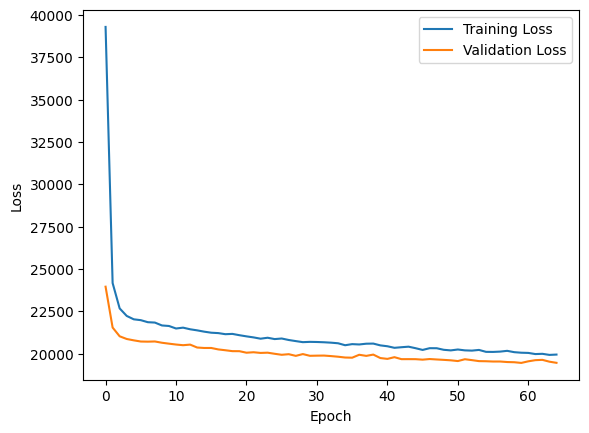

In [60]:
predict_preprocess_params = {
    "IT": PreprocessParams(
        WITH_SKILLS=True,
        WITH_GRADE=True,
        WITH_AREA=True,
        PROF_LIST=income_names_IT,
    ),
    "1C": PreprocessParams(
        WITH_SKILLS=True,
        WITH_GRADE=True,
        WITH_AREA=True,
        PROF_LIST=income_names_1C,
    ),
    "other": PreprocessParams(
        WITH_SKILLS=True,
        WITH_GRADE=True,
        WITH_AREA=True,
        PROF_LIST=income_names_other
    ),
    "all_data": PreprocessParams(
        WITH_SKILLS=True,
        WITH_GRADE=True,
        WITH_AREA=True,
        IS_PCA_ENABLE=False,
        PROF_LIST=[],
        WHITELIST=False,
        CALC_SKILLS=False,
        VERBOSE=False,
    )
}

results_predict = {}

width = 40

for key, params in predict_preprocess_params.items():
    print(colored(f"{key:-^{width}}", 'green'))

    params.BASIC_TRANSFORM = True
    df_basic: pd.DataFrame = get_preprocess_pipeline(params).fit_transform(df_original)
    display(df_basic)

    target_basic = df_basic['salary_average']

    params.BASIC_TRANSFORM = False
    pipeline = get_prediction_pipeline(params).fit(df_basic)
    df_processed = pipeline.transform(df_basic)

    target = df_processed['salary_average']
    X = df_processed.drop(['salary_from_gross', 'salary_to_gross', 'salary_average'], axis=1)

    display(df_processed)

    if key != 'all_data':
        model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
        model = train_model(X, target, model)
    else:
        model = SparseRegressionModel(X.values.shape[1]).to(device)
        train_DL_model(X, target, model)
    
    results_predict[key] = {
        "data_before": df_basic,
        "data_after": df_processed,
        "pipe": pipeline,
        "Params": params,
        "pretrained_model": model
    }

In [61]:
export_results_for_prediction(results_predict)


>>> Folder was created: /home/kitsu/ML_HR/Notebooks/output/IT
>>> Data frames were exported
>>> Model was exported
>>> Preprocessing params were exported
>>> Pipeline was exported

>>> Folder was created: /home/kitsu/ML_HR/Notebooks/output/1C
>>> Data frames were exported
>>> Model was exported
>>> Preprocessing params were exported
>>> Pipeline was exported

>>> Folder was created: /home/kitsu/ML_HR/Notebooks/output/other
>>> Data frames were exported
>>> Model was exported
>>> Preprocessing params were exported
>>> Pipeline was exported

>>> Folder was created: /home/kitsu/ML_HR/Notebooks/output/all_data
>>> All data is processing. Skip saving DataFrames
>>> Model was exported
>>> Preprocessing params were exported
>>> Pipeline was exported

>>> Arhive was created: /home/kitsu/ML_HR/Notebooks/output.zip
